In [1]:
from glob import glob
import numpy as np
import json
import pandas as pd

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
data = 'cifar10'

# Test Accuracy Comparison

In [3]:
def summarize_final_results(data='cifar10', split='test', n_last=20):
    '''
    Calculate the mean and standard deviation of results of the last 'n_last' epochs.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            try:
                exp_name = '{}_{}_{}'.format(data, model, str(sample))
                path_list = sorted(
                            glob(
                                '../experiments/{}/{}.*@{}-1/accuracies.txt'.format(model, data, sample)
                            ))
                tmp = []
                for path in path_list:
                    f = json.load(open(path, "r"))
                    tmp.append(pd.DataFrame(f, index=split_list))
                try:
                    tmp = pd.concat(tmp, sort=False)
                    tmp_test = tmp.loc['test'].iloc[:,-n_last:]
                except:
                    print('Based on the only one seed', model, sample, len(path_list))
                    tmp_test = tmp.loc['test'].iloc[-n_last:]

                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                            'mean': tmp_test.mean().mean(),
                            'std': tmp_test.std().mean()}
                df = df.append(tmp_dict, ignore_index=True)
            except:
                print(model, data, sample)
                pass

    return df

In [4]:
def show_summary_plot(data='cifar10'):
    df_data = summarize_final_results(data=data, n_last=20)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    names=['ERM','Mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    colors=['gray', 'red', 'skyblue', 'dodgerblue','blue', 'darkslateblue', 'navy']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    #plt.ylim(86,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

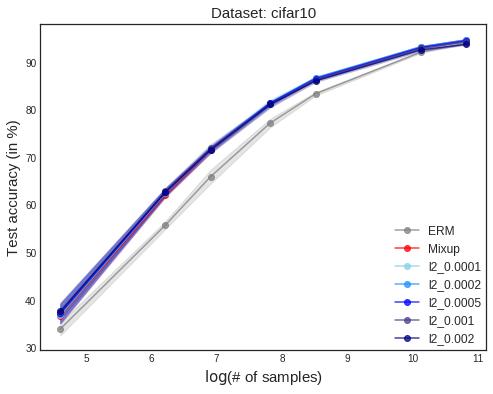

In [5]:
show_summary_plot(data=data)

In [6]:
def summary_table(data='cifar10'):
    df_data = summarize_final_results(data, n_last=20)
    ncol = 2 + len(df_data['model'].drop_duplicates())
    nrow = 1 + len(df_data['sample'].drop_duplicates())
    model_names = [data.replace('_', '-') for data in df_data['model'].drop_duplicates()]
    line = str(r'\begin{tabular}{|' + 'c|'*ncol + '}\n'
               + r'\hline' + '\n'
              )
    line = line + r'Dataset & Sample size'
    for model_name in model_names:
        line = line + ' & ' + model_name
    line = line + r'\tabularnewline' + '\n'
    line = line + str(r'\hline' + '\n'
                      + r'\hline' + '\n'
                      + r'\multirow{5}{*}{%s}' % df_data['data'][0] + '\n'
                     ) 
    for sample in sorted(df_data['sample'].drop_duplicates()):
        line = line + '& %d ' % sample
        for model in df_data['model'].drop_duplicates():
            ind = (df_data['sample'] == sample) & (df_data['model'] == model)
            line = line + r'& %.2f $\pm$ %.2f ' % (df_data['mean'][ind], df_data['std'][ind])
        line = line + r'\tabularnewline' + '\n'
        line = line + r'\cline{2-%d}' % ncol + '\n'
    line = line[:-12]
    line = line + r'\hline' + '\n' + r'\end{tabular}'
    return line

In [7]:
print(summary_table(data=data))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 34.00 $\pm$ 1.36 & 36.69 $\pm$ 1.63 & 36.86 $\pm$ 1.62 & 37.08 $\pm$ 1.84 & 37.26 $\pm$ 2.02 & 37.53 $\pm$ 2.04 & 37.68 $\pm$ 1.68 \tabularnewline
\cline{2-9}
& 500 & 55.83 $\pm$ 0.82 & 62.10 $\pm$ 0.44 & 62.62 $\pm$ 0.68 & 62.52 $\pm$ 0.66 & 62.73 $\pm$ 0.79 & 62.96 $\pm$ 0.70 & 62.80 $\pm$ 0.87 \tabularnewline
\cline{2-9}
& 1000 & 66.03 $\pm$ 1.45 & 71.69 $\pm$ 0.58 & 72.06 $\pm$ 0.43 & 71.87 $\pm$ 0.61 & 71.91 $\pm$ 0.38 & 72.06 $\pm$ 0.80 & 71.62 $\pm$ 0.68 \tabularnewline
\cline{2-9}
& 2500 & 77.33 $\pm$ 0.90 & 81.51 $\pm$ 0.34 & 81.56 $\pm$ 0.41 & 81.52 $\pm$ 0.68 & 81.52 $\pm$ 0.26 & 81.26 $\pm$ 0.38 & 81.23 $\pm$ 0.63 \tabularnewline
\cline{2-9}
& 5000 & 83.45 $\pm$ 0.38 & 86.56 $\pm$ 0.23 & 86.67 $\pm$ 0.28 & 86.84 $\pm$ 0.20 & 86.63 $\pm$ 0.28 & 86.42 $\pm$ 0.22 & 86.16 $\pm$ 0.2

# Experiments with Noisy Image

In [8]:
def summarize_noise_results(data='cifar10', **kwargs):
    '''
    Calculate the mean and standard deviation of accuracies with noisy images.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    mean = kwargs.get('mean', 0)
    var = kwargs.get('var', None)
    mode = kwargs.get('mode', None)
    p = kwargs.get('p', None)
    if mode is 'gaussian':
        noise_settings = {'Mode':'gaussian', 'Mean':mean, 'Var':var, 'seed':None}
    elif mode is not None:
        noise_settings = {'Mode':mode, 'p':p, 'seed':None}
    else:
        assert False, 'mode is None'
    
    models = ['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    split_list = ['noise_tr','noise_val','noise_test','gap_tr','gap_val','gap_test']
    df = pd.DataFrame(columns=['data','model','sample','noise_settings',
                               'noise_tr_mean','noise_tr_std','noise_test_mean','noise_test_std',
                               'gap_tr_mean','gap_tr_std','gap_test_mean','gap_test_std',])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/{}/{}.*@{}-1/noise.txt'.format(model, data, sample)
                        ))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                acc = f[str(noise_settings)]
                # acc: [noise_tr, noise_val, noise_test, tr, val, test]
                acc[3] = acc[0] - acc[3]
                acc[4] = acc[1] - acc[4]
                acc[5] = acc[2] - acc[5]
                tmp.append(pd.DataFrame(acc, index=split_list))
            tmp = pd.concat(tmp, sort=False)
            tmp_mean = tmp.groupby(level=0).mean()
            tmp_std = tmp.groupby(level=0).std()
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'noise_settings':str(noise_settings),
                        'noise_tr_mean': tmp_mean.loc['noise_tr'].iloc[0],
                        'noise_tr_std': tmp_std.loc['noise_tr'].iloc[0],
                        'noise_test_mean': tmp_mean.loc['noise_test'].iloc[0],
                        'noise_test_std': tmp_std.loc['noise_test'].iloc[0],
                        'gap_tr_mean': tmp_mean.loc['gap_tr'].iloc[0],
                        'gap_tr_std': tmp_std.loc['gap_tr'].iloc[0],
                        'gap_test_mean': tmp_mean.loc['gap_test'].iloc[0],
                        'gap_test_std': tmp_std.loc['gap_test'].iloc[0]
                       }
            df = df.append(tmp_dict, ignore_index=True)
    return df

In [9]:
def show_noise_plot(data='cifar10', split='train', **kwargs):
    df_data = summarize_noise_results(data=data, **kwargs)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    names=['ERM','Mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    colors=['gray', 'red', 'skyblue', 'dodgerblue', 'blue', 'darkslateblue', 'navy']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}, Noise:{}'.format(data, df_data['noise_settings'][0]), fontsize=15)
    
    if split is 'train':
        for i in range(len(colors)):
            #train plot
            #ymean = df_data['tr_mean'][df_data['model']==models[i]]
            #yerr = df_data['tr_std'][df_data['model']==models[i]]
            #plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
            #plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
            #noise plot
            ymean = df_data['noise_tr_mean'][df_data['model']==models[i]]
            yerr = df_data['noise_tr_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], alpha=0.5) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.1, edgecolor=colors[i], facecolor=colors[i])
    elif split is 'test':
        for i in range(len(colors)):
            #test plot
            #ymean = df_data['test_mean'][df_data['model']==models[i]]
            #yerr = df_data['test_std'][df_data['model']==models[i]]
            #plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
            #plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
            #test plot
            ymean = df_data['noise_test_mean'][df_data['model']==models[i]]
            yerr = df_data['noise_test_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], label=names[i], alpha=0.75) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.3, edgecolor=colors[i], facecolor=colors[i])
    else:
        assert False, 'check split (train or test)'
    #plt.ylim(75,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

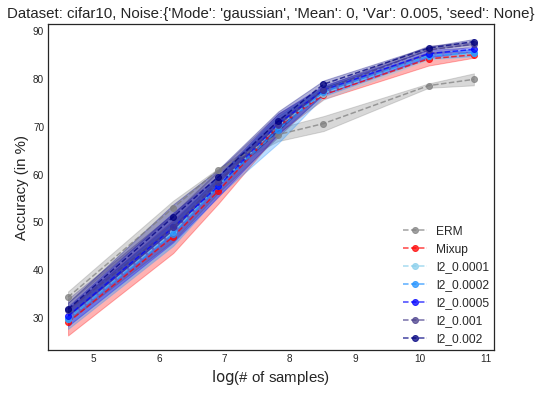

In [10]:
show_noise_plot(data=data, split='test', mode='gaussian', var=0.005)

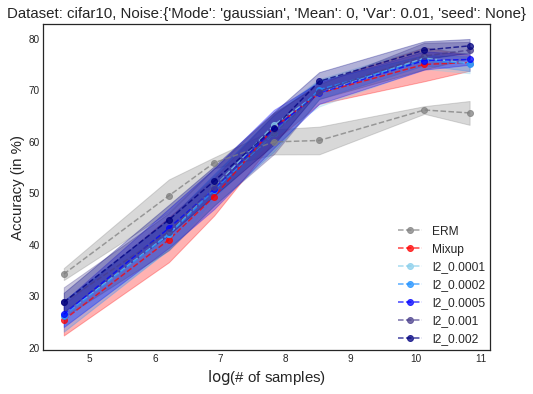

In [11]:
show_noise_plot(data=data, split='test', mode='gaussian', var=0.01)

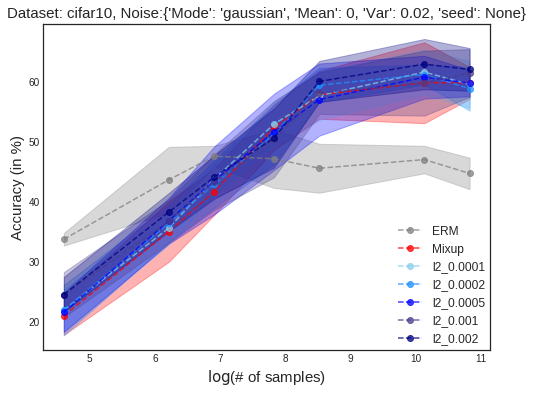

In [12]:
show_noise_plot(data=data, split='test', mode='gaussian', var=0.02)

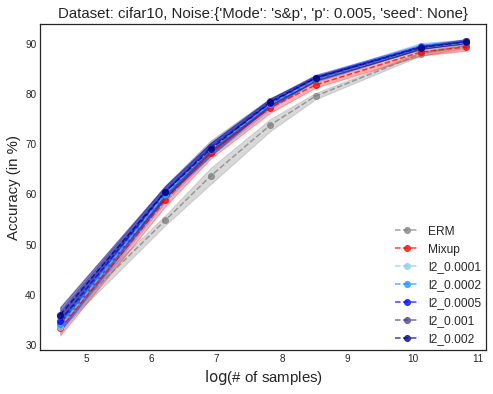

In [13]:
show_noise_plot(data=data, split='test', mode='s&p', p=0.005)

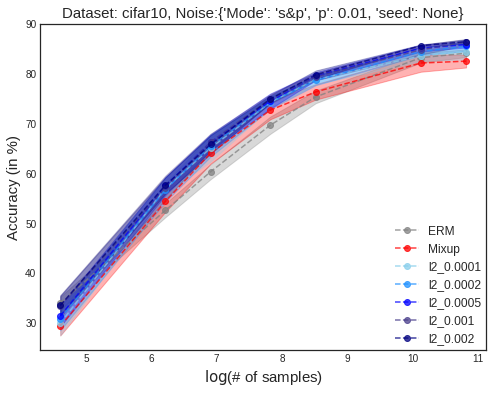

In [14]:
show_noise_plot(data=data, split='test', mode='s&p', p=0.01)

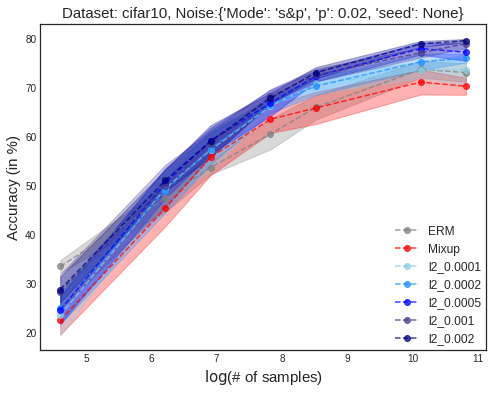

In [15]:
show_noise_plot(data=data, split='test', mode='s&p', p=0.02)

In [16]:
def summary_noise_table(data=data, split='test', **kwargs):
    df_data = summarize_noise_results(data, split=split, **kwargs)
    ncol = 2 + len(df_data['model'].drop_duplicates())
    nrow = 1 + len(df_data['sample'].drop_duplicates())
    model_names = [data.replace('_', '-') for data in df_data['model'].drop_duplicates()]
    line = str(r'\begin{tabular}{|' + 'c|'*ncol + '}\n'
               + r'\hline' + '\n'
              )
    line = line + r'Dataset & Sample size'
    for model_name in model_names:
        line = line + ' & ' + model_name
    line = line + r'\tabularnewline' + '\n'
    line = line + str(r'\hline' + '\n'
                      + r'\hline' + '\n'
                      + r'\multirow{5}{*}{%s}' % df_data['data'][0] + '\n'
                     ) 
    for sample in sorted(df_data['sample'].drop_duplicates()):
        if split is 'test':
            mean_ind, std_ind = 'noise_test_mean', 'noise_test_std'
        elif split is 'train':
            mean_ind, std_ind = 'noise_tr_mean', 'noise_tr_std'
        else:
            assert False, 'split must be train or test'
        line = line + '& %d ' % sample
        for model in df_data['model'].drop_duplicates():
            ind = (df_data['sample'] == sample) & (df_data['model'] == model)
            line = line + r'& %.2f $\pm$ %.2f ' % (df_data[mean_ind][ind], df_data[std_ind][ind])
        line = line + r'\tabularnewline' + '\n'
        line = line + r'\cline{2-%d}' % ncol + '\n'
    line = line[:-12]
    line = line + r'\hline' + '\n' + r'\end{tabular}'
    return line

In [17]:
print(summary_noise_table(data=data, mode='gaussian', var=0.005))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 34.38 $\pm$ 1.19 & 29.11 $\pm$ 2.74 & 29.83 $\pm$ 1.51 & 29.90 $\pm$ 2.17 & 30.42 $\pm$ 2.05 & 31.69 $\pm$ 2.35 & 31.88 $\pm$ 1.35 \tabularnewline
\cline{2-9}
& 500 & 53.01 $\pm$ 1.51 & 47.00 $\pm$ 3.42 & 47.96 $\pm$ 2.64 & 47.56 $\pm$ 2.49 & 48.93 $\pm$ 3.11 & 48.96 $\pm$ 2.88 & 51.12 $\pm$ 2.63 \tabularnewline
\cline{2-9}
& 1000 & 60.94 $\pm$ 0.37 & 56.57 $\pm$ 2.63 & 57.69 $\pm$ 1.54 & 57.59 $\pm$ 2.01 & 57.56 $\pm$ 2.18 & 58.52 $\pm$ 2.34 & 59.54 $\pm$ 1.53 \tabularnewline
\cline{2-9}
& 2500 & 68.34 $\pm$ 1.36 & 70.09 $\pm$ 1.45 & 70.22 $\pm$ 1.16 & 69.40 $\pm$ 2.86 & 70.60 $\pm$ 2.17 & 70.30 $\pm$ 2.40 & 71.17 $\pm$ 2.01 \tabularnewline
\cline{2-9}
& 5000 & 70.64 $\pm$ 1.56 & 76.66 $\pm$ 0.91 & 76.91 $\pm$ 1.28 & 77.30 $\pm$ 0.93 & 77.65 $\pm$ 0.94 & 77.68 $\pm$ 0.70 & 78.85 $\pm$ 0.7

In [18]:
print(summary_noise_table(data=data, mode='gaussian', var=0.01))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 34.28 $\pm$ 1.16 & 25.35 $\pm$ 3.01 & 26.38 $\pm$ 2.21 & 26.11 $\pm$ 3.03 & 26.46 $\pm$ 2.49 & 28.80 $\pm$ 2.91 & 28.80 $\pm$ 1.85 \tabularnewline
\cline{2-9}
& 500 & 49.51 $\pm$ 3.17 & 40.95 $\pm$ 4.36 & 42.05 $\pm$ 3.10 & 41.99 $\pm$ 2.91 & 43.21 $\pm$ 3.82 & 42.52 $\pm$ 3.61 & 44.84 $\pm$ 2.91 \tabularnewline
\cline{2-9}
& 1000 & 55.91 $\pm$ 1.07 & 49.33 $\pm$ 3.67 & 51.17 $\pm$ 2.20 & 50.64 $\pm$ 3.07 & 50.88 $\pm$ 3.96 & 51.22 $\pm$ 3.59 & 52.38 $\pm$ 2.87 \tabularnewline
\cline{2-9}
& 2500 & 59.98 $\pm$ 2.43 & 62.75 $\pm$ 2.62 & 63.26 $\pm$ 2.31 & 61.67 $\pm$ 3.55 & 62.53 $\pm$ 3.70 & 61.64 $\pm$ 4.01 & 62.64 $\pm$ 3.15 \tabularnewline
\cline{2-9}
& 5000 & 60.26 $\pm$ 2.69 & 69.44 $\pm$ 2.06 & 69.53 $\pm$ 2.65 & 70.14 $\pm$ 1.81 & 69.51 $\pm$ 2.12 & 69.75 $\pm$ 1.44 & 71.76 $\pm$ 1.7

In [19]:
print(summary_noise_table(data=data, mode='gaussian', var=0.02))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 33.84 $\pm$ 1.05 & 21.13 $\pm$ 3.21 & 22.05 $\pm$ 3.44 & 22.03 $\pm$ 4.21 & 21.66 $\pm$ 3.28 & 24.63 $\pm$ 3.75 & 24.64 $\pm$ 2.93 \tabularnewline
\cline{2-9}
& 500 & 43.76 $\pm$ 5.50 & 35.14 $\pm$ 5.04 & 35.74 $\pm$ 2.83 & 36.52 $\pm$ 3.12 & 36.93 $\pm$ 3.81 & 36.85 $\pm$ 3.59 & 38.39 $\pm$ 3.19 \tabularnewline
\cline{2-9}
& 1000 & 47.69 $\pm$ 1.73 & 41.76 $\pm$ 3.87 & 43.85 $\pm$ 2.49 & 43.01 $\pm$ 3.96 & 43.64 $\pm$ 5.67 & 43.36 $\pm$ 4.62 & 44.21 $\pm$ 3.61 \tabularnewline
\cline{2-9}
& 2500 & 47.27 $\pm$ 4.87 & 52.48 $\pm$ 3.78 & 53.03 $\pm$ 3.76 & 51.33 $\pm$ 4.97 & 51.74 $\pm$ 6.37 & 50.53 $\pm$ 6.35 & 50.71 $\pm$ 4.91 \tabularnewline
\cline{2-9}
& 5000 & 45.68 $\pm$ 4.08 & 57.92 $\pm$ 4.00 & 57.77 $\pm$ 4.03 & 59.52 $\pm$ 2.89 & 57.12 $\pm$ 6.01 & 58.20 $\pm$ 3.46 & 60.15 $\pm$ 3.4

In [20]:
print(summary_noise_table(data=data, mode='s&p', p=0.005))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 34.35 $\pm$ 1.28 & 33.28 $\pm$ 1.41 & 33.59 $\pm$ 1.39 & 34.25 $\pm$ 1.63 & 34.80 $\pm$ 1.99 & 35.74 $\pm$ 1.84 & 36.01 $\pm$ 1.52 \tabularnewline
\cline{2-9}
& 500 & 54.84 $\pm$ 0.98 & 58.80 $\pm$ 1.16 & 60.15 $\pm$ 0.85 & 59.92 $\pm$ 1.45 & 60.49 $\pm$ 1.23 & 60.51 $\pm$ 1.27 & 60.53 $\pm$ 1.15 \tabularnewline
\cline{2-9}
& 1000 & 63.65 $\pm$ 1.62 & 68.30 $\pm$ 1.17 & 68.94 $\pm$ 1.33 & 68.94 $\pm$ 1.28 & 69.40 $\pm$ 0.85 & 69.41 $\pm$ 1.30 & 68.98 $\pm$ 1.31 \tabularnewline
\cline{2-9}
& 2500 & 73.84 $\pm$ 1.20 & 77.31 $\pm$ 1.02 & 78.05 $\pm$ 0.35 & 77.96 $\pm$ 1.03 & 78.20 $\pm$ 0.87 & 78.53 $\pm$ 0.69 & 78.43 $\pm$ 0.74 \tabularnewline
\cline{2-9}
& 5000 & 79.60 $\pm$ 0.62 & 81.82 $\pm$ 0.54 & 82.92 $\pm$ 0.41 & 83.15 $\pm$ 0.40 & 83.24 $\pm$ 0.62 & 83.02 $\pm$ 0.54 & 83.20 $\pm$ 0.5

In [21]:
print(summary_noise_table(data=data, mode='s&p', p=0.01))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 33.99 $\pm$ 1.30 & 29.39 $\pm$ 1.86 & 29.96 $\pm$ 2.43 & 30.87 $\pm$ 2.31 & 31.42 $\pm$ 2.11 & 33.41 $\pm$ 2.20 & 33.55 $\pm$ 1.93 \tabularnewline
\cline{2-9}
& 500 & 52.64 $\pm$ 1.38 & 54.42 $\pm$ 2.09 & 57.03 $\pm$ 0.96 & 56.78 $\pm$ 2.42 & 57.50 $\pm$ 1.79 & 57.20 $\pm$ 2.41 & 57.67 $\pm$ 1.66 \tabularnewline
\cline{2-9}
& 1000 & 60.39 $\pm$ 1.50 & 64.14 $\pm$ 2.13 & 65.16 $\pm$ 2.72 & 65.58 $\pm$ 2.13 & 66.30 $\pm$ 1.65 & 66.37 $\pm$ 1.66 & 65.86 $\pm$ 1.88 \tabularnewline
\cline{2-9}
& 2500 & 69.76 $\pm$ 1.73 & 72.78 $\pm$ 1.84 & 74.32 $\pm$ 1.03 & 74.30 $\pm$ 1.30 & 74.59 $\pm$ 1.52 & 75.04 $\pm$ 0.97 & 75.02 $\pm$ 0.76 \tabularnewline
\cline{2-9}
& 5000 & 75.42 $\pm$ 1.26 & 76.43 $\pm$ 1.55 & 78.90 $\pm$ 0.94 & 78.73 $\pm$ 0.97 & 79.57 $\pm$ 0.81 & 79.46 $\pm$ 0.73 & 79.86 $\pm$ 0.8

In [22]:
print(summary_noise_table(data=data, mode='s&p', p=0.02))

\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0001 & l2-0.0002 & l2-0.0005 & l2-0.001 & l2-0.002\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 33.56 $\pm$ 1.31 & 22.60 $\pm$ 2.90 & 23.69 $\pm$ 4.17 & 25.01 $\pm$ 3.18 & 24.72 $\pm$ 2.84 & 28.44 $\pm$ 3.55 & 28.86 $\pm$ 2.65 \tabularnewline
\cline{2-9}
& 500 & 47.44 $\pm$ 2.79 & 45.45 $\pm$ 3.70 & 49.43 $\pm$ 1.78 & 48.98 $\pm$ 4.45 & 50.54 $\pm$ 3.07 & 50.05 $\pm$ 4.24 & 51.11 $\pm$ 2.16 \tabularnewline
\cline{2-9}
& 1000 & 53.72 $\pm$ 1.40 & 55.82 $\pm$ 3.64 & 57.31 $\pm$ 4.28 & 57.56 $\pm$ 3.15 & 59.17 $\pm$ 2.65 & 58.55 $\pm$ 2.59 & 59.06 $\pm$ 3.29 \tabularnewline
\cline{2-9}
& 2500 & 60.53 $\pm$ 3.14 & 63.55 $\pm$ 2.78 & 66.24 $\pm$ 0.85 & 66.41 $\pm$ 1.65 & 66.84 $\pm$ 2.67 & 68.28 $\pm$ 1.40 & 67.82 $\pm$ 1.07 \tabularnewline
\cline{2-9}
& 5000 & 65.95 $\pm$ 2.49 & 65.83 $\pm$ 3.27 & 70.66 $\pm$ 1.88 & 70.27 $\pm$ 1.77 & 72.33 $\pm$ 1.09 & 72.53 $\pm$ 1.31 & 73.02 $\pm$ 1.1

In [23]:
def show_noise_gap_plot(data='cifar10', split='train', **kwargs):
    df_data = summarize_noise_results(data=data, **kwargs)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    names=['ERM','Mixup','l2_0.0001','l2_0.0002','l2_0.0005','l2_0.001','l2_0.002']
    colors=['gray', 'red', 'skyblue', 'dodgerblue', 'blue', 'darkslateblue', 'navy']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}, Noise:{}'.format(data, df_data['noise_settings'][0]), fontsize=15)
    
    if split is 'train':
        for i in range(len(colors)):
            ymean = df_data['gap_tr_mean'][df_data['model']==models[i]]
            yerr = df_data['gap_tr_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], alpha=0.5, label=names[i]) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.1, edgecolor=colors[i], facecolor=colors[i])
    elif split is 'test':
        for i in range(len(colors)):
            #test plot
            ymean = df_data['gap_test_mean'][df_data['model']==models[i]]
            yerr = df_data['gap_test_std'][df_data['model']==models[i]]
            plt.plot(np.log(x_list), ymean, '--', marker='o', color=colors[i], label=names[i], alpha=0.75) 
            plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.3, edgecolor=colors[i], facecolor=colors[i])
    else:
        assert False, 'check split (train or test)'
    #plt.ylim(75,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

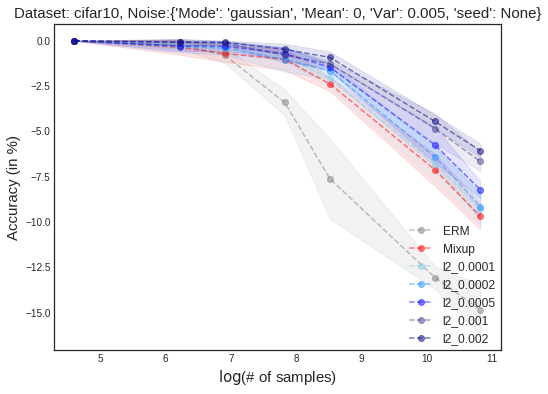

In [24]:
show_noise_gap_plot(data=data, split='train', mode='gaussian', var=0.005)

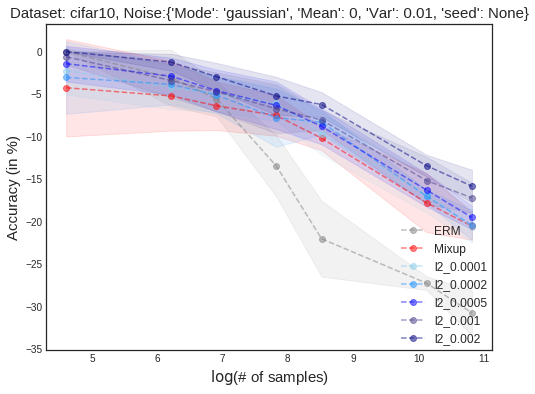

In [25]:
show_noise_gap_plot(data=data, split='train', mode='gaussian', var=0.01)

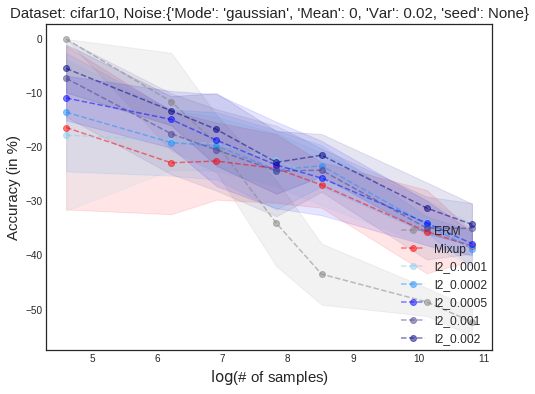

In [26]:
show_noise_gap_plot(data=data, split='train', mode='gaussian', var=0.02)

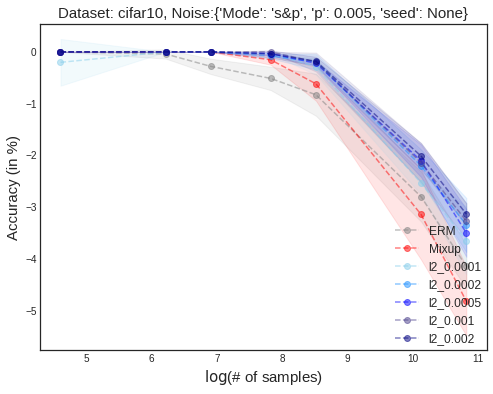

In [27]:
show_noise_gap_plot(data=data, split='train', mode='s&p', p=0.005)

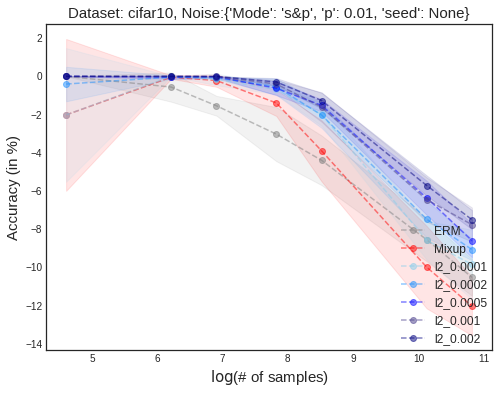

In [28]:
show_noise_gap_plot(data=data, split='train', mode='s&p', p=0.01)

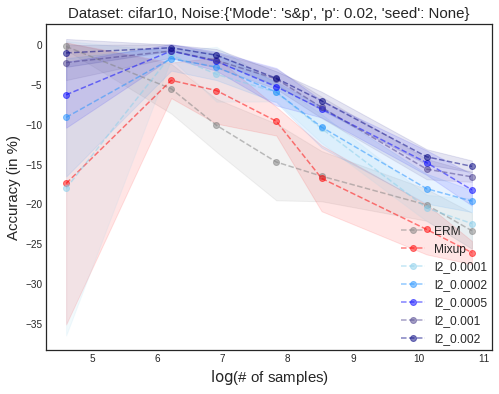

In [29]:
show_noise_gap_plot(data=data, split='train', mode='s&p', p=0.02)

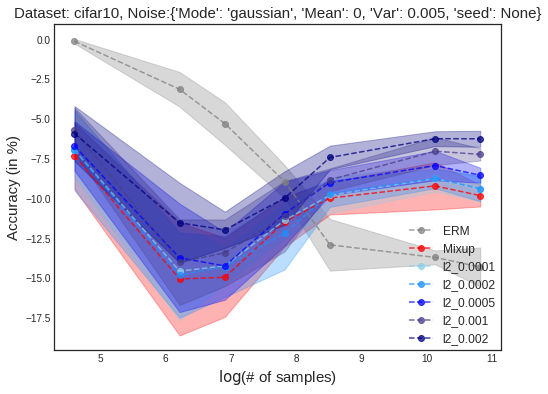

In [30]:
show_noise_gap_plot(data=data, split='test', mode='gaussian', var=0.005)

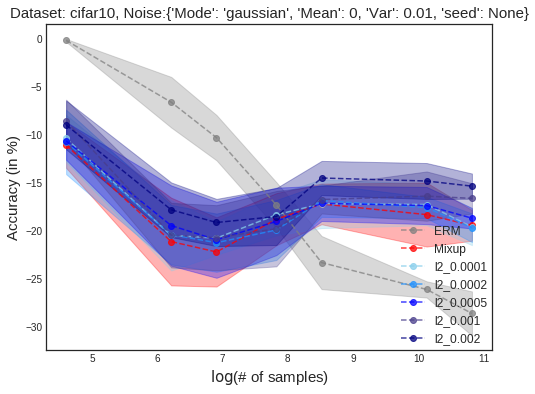

In [31]:
show_noise_gap_plot(data=data, split='test', mode='gaussian', var=0.01)

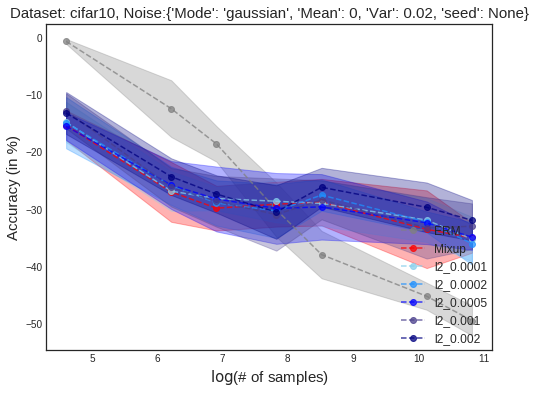

In [32]:
show_noise_gap_plot(data=data, split='test', mode='gaussian', var=0.02)

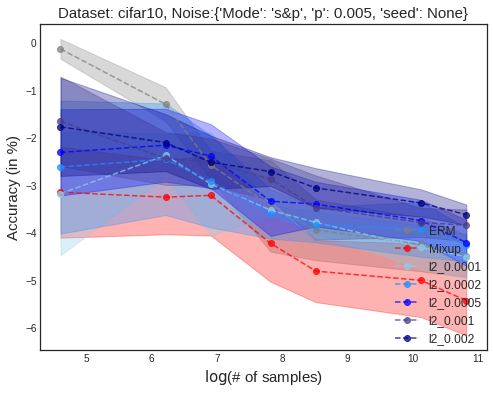

In [33]:
show_noise_gap_plot(data=data, split='test', mode='s&p', p=0.005)

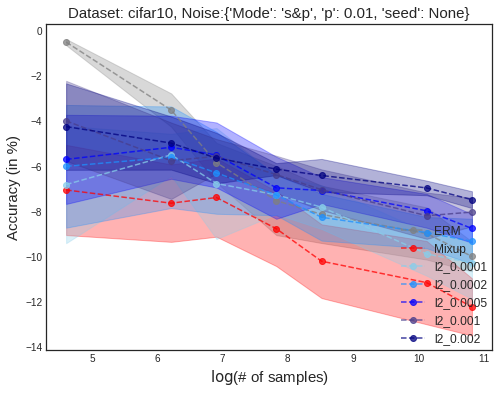

In [34]:
show_noise_gap_plot(data=data, split='test', mode='s&p', p=0.01)

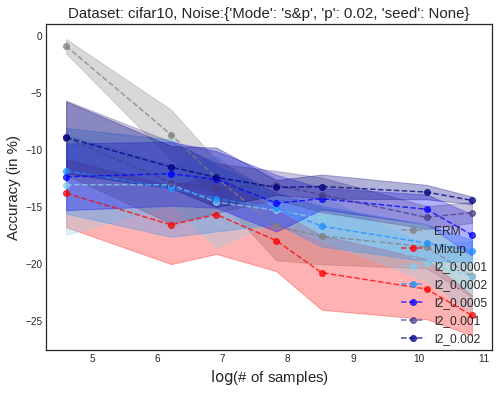

In [35]:
show_noise_gap_plot(data=data, split='test', mode='s&p', p=0.02)

# Experiments with Gradients (Under Construction)

In [36]:
def show_lipschitz_plot(data=dataset):
    df_data = summarize_gradients(data=data)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    #models=['erm','mixup','l2_0.0005_','l2_0.0025_','l2_0.001_']
    #names=['ERM','Mixup','l2_0.0005','l2_0.0025','l2_0.001']
    #colors=['dodgerblue','yellowgreen','red','purple','blue']
    models=['l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red']
    
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Lipschitz', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    #plt.ylim(86,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

NameError: name 'dataset' is not defined

In [ ]:
def summarize_gradients(data=dataset):
    '''
    Summarize the gradients for each models
    '''
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','l2_0.0001','l2_0.0002']
    df = pd.DataFrame(columns=['data','model','sample', 'gradients'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                glob(
                    '../experiments/{}/{}*@{}-1/accuracies.txt'.format(model, data, sample)
                )
            )
            tmp = []
            for path in path_list:
                f = json.load(open(path_list[0], "r"))
                tmp = tmp + f['gradients']
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'gradients': tmp
                       }
            df = df.append(tmp_dict, ignore_index=True)
    return df

In [ ]:
def show_lipschitz_plot(data=dataset):
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel(r'$||\nabla_x h||_{\infty}$', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    df = summarize_gradients(dataset)
    x = df['sample'].drop_duplicates().values
    x_array = np.log(np.array(x, dtype='float32'))
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    for i, model in enumerate(df['model'].drop_duplicates()):
        avg = np.array([])
        sd = np.array([])
        for sample in df['sample'].drop_duplicates():
            ind = (df['model'] == model) & (df['sample'] == sample)
            gradients = df['gradients'][ind].values[0]
            avg= np.append(avg, np.mean(gradients))
            sd= np.append(sd, np.std(gradients))
        plt.plot(x_array, avg, marker='o', label=model, color=colors[i], alpha=0.75)
        plt.fill_between(x_array, avg-sd, avg+sd, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    plt.legend()
    plt.show()

In [ ]:
show_lipschitz_plot(dataset)

# Epochs vs Test accuracy

In [ ]:
def summarize_learning_history(data='cifar10'):
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models=['erm','mixup','l2_0.0005_','l2_0.0025_','l2_0.001_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/acc_all/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                        ))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            tmp = pd.concat(tmp, sort=False)
            test_acc = tmp.loc['test'].values
            
            try:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': np.mean(test_acc, axis=0),
                           'std': np.std(test_acc, axis=0)}
            except:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(test_acc),
                           'std': np.zeros(len(list(test_acc)))}
                
            
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [ ]:
def plot_test_acc(data=dataset, sample=50000):
    df = summarize_learning_history(dataset)
    x_list = np.arange(100)
    
    models=['erm','mixup','l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['ERM','Mixup','l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset-sample size:{}-{}'.format(data,sample), fontsize=15)
    
    for i in range(len(colors)):
        ind = (df['model']==models[i]) & (df['sample']==sample)
        ymean = df['mean'][ind].values[0]
        yerr = df['std'][ind].values[0]
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.5) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
        
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    #plt.ylim(4,5.5)
    plt.show()

In [ ]:
plot_test_acc(data=dataset,sample=100)

In [ ]:
plot_test_acc(data=dataset,sample=500)

In [ ]:
plot_test_acc(data=dataset,sample=1000)

In [ ]:
plot_test_acc(data=dataset,sample=2500)

In [ ]:
plot_test_acc(data=dataset,sample=5000)

In [ ]:
plot_test_acc(data=dataset,sample=25000)

In [ ]:
plot_test_acc(data=dataset,sample=50000)